In [1]:
# -*- coding: utf-8 -*-
"""malicious_url_detection_with_lstm.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1hADJtSBNoL69A29ccojiYwL7lBTrp13J
"""

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


./malicious_phish3.csv
./.config/.last_survey_prompt.yaml
./.config/gce
./.config/config_sentinel
./.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
./.config/.last_opt_in_prompt.yaml
./.config/default_configs.db
./.config/.last_update_check.json
./.config/active_config
./.config/configurations/config_default
./.config/logs/2025.02.03/14.19.53.204509.log
./.config/logs/2025.02.03/14.20.32.773896.log
./.config/logs/2025.02.03/14.20.21.751909.log
./.config/logs/2025.02.03/14.20.22.741612.log
./.config/logs/2025.02.03/14.20.13.328083.log
./.config/logs/2025.02.03/14.20.32.162797.log
./sample_data/README.md
./sample_data/anscombe.json
./sample_data/california_housing_test.csv
./sample_data/california_housing_train.csv
./sample_data/mnist_test.csv
./sample_data/mnist_train_small.csv


In [2]:
!pip install whois
!pip install pyquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("sklearn version", sklearn.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0
sklearn version 1.6.1


# DEFINITOIN OF URL FEATURE EXTRACTİON CLASS
### Feature Extraction Steps
* extract entropy
* extract count of digits
* extract url lenght
* extract count of parameters
* extract count of fragments
* extract count of subdomain
* extract domain extention
* extract http and https
* extract if is ip address
* return values of dict


In [4]:
# Vérification du GPU et activation de XLA pour accélérer les calculs
print(f"TensorFlow Version: {tf.__version__}")
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Activation du mode Mixed Precision pour accélérer l'entraînement et réduire la mémoire
tf.keras.mixed_precision.set_global_policy("mixed_float16")


import math

class FeatureExtractor:
    def __init__(self, url=""):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
    # Özellikler
    def url_entropy(self):
        url_trimmed = self.url.strip()
        entropy_distribution = [float(url_trimmed.count(c)) / len(url_trimmed) for c in dict.fromkeys(list(url_trimmed))]
        return -sum([e * math.log(e, 2) for e in entropy_distribution if e > 0])

    def digits_num(self):
        return len([i for i in self.url if i.isdigit()])

    def length(self):
        return len(self.url)

    def params_num(self):
        return len(self.url.split('&')) - 1

    def fragments_num(self):
        return len(self.url.split('#')) - 1

    def subdomain_num(self):
        return len(self.domain.split('.')) - 1

    def dom_ext(self):
        return self.domain.split('.')[-1]

    def has_http(self):
        return 'http' in self.url

    def has_https(self):
        return 'https' in self.url

    def is_ip(self):
        parts = self.domain.split('.')
        if len(parts) == 4 and all(part.isdigit() and 0 <= int(part) <= 255 for part in parts):
            return True
        return False

    def run(self):
        return {
            "url": self.url,
            "entropy": self.url_entropy(),
            "digits": self.digits_num(),
            "url_length": self.length(),
            "param_nums": self.params_num(),
            "fragment_nums": self.fragments_num(),
            "subdomain_nums": self.subdomain_num(),
            "domain_extension": self.dom_ext(),
            "has_http": self.has_http(),
            "has_https": self.has_https(),
            "is_ip": self.is_ip(),
            "num_%20" : self.url.count("%20"),
            "num_@" : self.url.count("@")
        }

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




### Extracion of Fetures

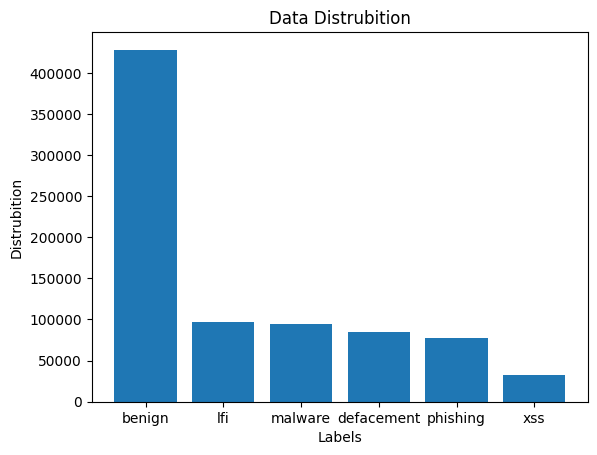

In [5]:
url = pd.read_csv(
    "./malicious_phish3.csv"
)
counts = url["type"].value_counts()
plt.bar(url["type"].unique(),counts)
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

<ipython-input-6-f78fb2654cd1>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = url.groupby("type").apply(lambda x: x.sample(n=min(len(x), 30000), random_state=42))


Final dataset label distribution: type
benign        30000
defacement    30000
lfi           30000
malware       30000
phishing      30000
xss           30000
Name: count, dtype: int64


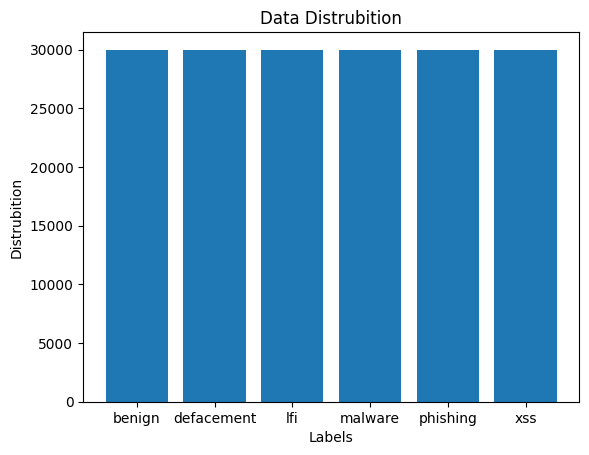

In [6]:
balanced_df = url.groupby("type").apply(lambda x: x.sample(n=min(len(x), 30000), random_state=42))
balanced_df = balanced_df.reset_index(drop=True)


print("Final dataset label distribution:", balanced_df["type"].value_counts())


plt.bar(balanced_df["type"].unique(),balanced_df['type'].value_counts())
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

In [7]:
from tqdm import tqdm
features = []
for url in tqdm(balanced_df['url']):
    features.append(FeatureExtractor(url).run())
print(len(features))
features_df = pd.DataFrame(features)

100%|██████████| 180000/180000 [00:12<00:00, 14381.40it/s]


180000


### Show New Data

In [8]:
features_df["type"] = balanced_df["type"]
features_df.head(5)

,url,entropy,digits,url_length,param_nums,fragment_nums,subdomain_nums,domain_extension,has_http,has_https,is_ip,num_%20,num_@,type
0,foxnews.com/sports/2011/10/07/blackhawks-stars...,4.412454,8,70,0,0,1,com,False,False,False,0,0,benign
1,mylife.com/c-634247090,4.095795,9,22,0,0,1,com,False,False,False,0,0,benign
2,mylife.com/c-1084655530,4.055958,10,23,0,0,1,com,False,False,False,0,0,benign
3,ibiblio.org/hyperwar/USN/ships/ships-pg.html,4.132965,0,44,0,0,1,org,False,False,False,0,0,benign
4,http://distractify.com/post/related/id/55535db...,4.455771,21,87,0,0,1,com,True,False,False,0,0,benign


###  Define a tokenier for url tokenizing

In [9]:
features_df = features_df.dropna(subset=['type'])
features_df.head()
features_df["type"].value_counts()

,count
type,
benign,30000
defacement,30000
lfi,30000
malware,30000
phishing,30000
xss,30000


In [10]:
#tokenizer = Tokenizer(oov_token="<OOV>") Trop lourd
tokenizer = Tokenizer(num_words=256, oov_token="<OOV>")
tokenizer.fit_on_texts(features_df["url"])
sequences = tokenizer.texts_to_sequences(features_df['url'])
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print("done")

done


 ### Defining a label encoder for encoding classes

In [11]:
from sklearn.preprocessing import LabelEncoder

# Define all 6 labels explicitly

all_labels = [
    "benign", "phishing", "defacement", "malware", "lfi", "xss"
]

# Train LabelEncoder with all labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)  # Ensure all labels are included

# Encode labels
features_df['type'] = label_encoder.transform(features_df['type'])


y = to_categorical(features_df['type'], num_classes=6)
y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

#### Converting extracted to numpy array

In [12]:
extra_features = features_df[['entropy', 'digits', 'url_length', 'param_nums',
                       'has_http', 'has_https', 'is_ip',
                       'num_%20', 'num_@']].astype(np.int32).values
labels = features_df['type'].astype(np.int32).values

### Configuring our neural network with extracted features
* Input layer for url input
* embedding layer
* lstm out layer for url
* Input Layer for extracted features
* Dense layer for extracted features

Merging lstm output and extracted fetures output
Dropout definition
Output layer with size 4

In [13]:
url_input = Input(shape=(100,), name="url_input")

#embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(url_input) Trop gourmand
embedding = Embedding(input_dim=256, output_dim=64)(url_input)
lstm_out = LSTM(64, return_sequences=False)(embedding)

features_input = Input(shape=(9,), name="extra_features")
dense_features = Dense(32, activation="relu")(features_input)

merged = Concatenate()([lstm_out, dense_features])
dense1 = Dense(64, activation="relu")(merged)
dropout = Dropout(0.5)(dense1)
output = Dense(6, activation="softmax", name="output")(dropout)


model = Model(inputs=[url_input, features_input], outputs=output)


model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ url_input (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ extra_features            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 64)        │         16,384 │ url_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 9)              │              0 │ extra_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         33,024 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            320 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ lstm[0][0],            │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          6,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │            390 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 56,326 (220.02 KB)

 Trainable params: 56,326 (220.02 KB)

 Non-trainable params: 0 (0.00 B)

### Training Model
* Splitting data with extracted and seq values
* training model with batch size 32 and 4 epochs

In [14]:
X_train_seq, X_test_seq, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    padded_sequences, extra_features, y, test_size=0.2, random_state=42
)

In [15]:


history = model.fit(
    [X_train_seq, X_train_extra], y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_test_seq, X_test_extra], y_test),
    verbose=1
)


Epoch 1/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - accuracy: 0.5574 - loss: 1.3768 - val_accuracy: 0.7502 - val_loss: 0.6448
Epoch 2/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.7119 - loss: 0.7452 - val_accuracy: 0.7386 - val_loss: 0.6242
Epoch 3/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - accuracy: 0.7220 - loss: 0.7115 - val_accuracy: 0.7569 - val_loss: 0.5976
Epoch 4/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.7318 - loss: 0.6790 - val_accuracy: 0.7546 - val_loss: 0.5832
Epoch 5/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.7354 - loss: 0.6632 - val_accuracy: 0.7683 - val_loss: 0.5779
Epoch 6/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.7384 - loss: 0.6528 - val_accuracy: 0.7622 - val_loss: 0.5689
Epoch 7/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.7444 - loss: 0.6378 - val_accuracy: 0.7691 - val_loss: 0.5662
Epoch 8/20
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.7458 -

## Report of model
printing loss and accuracy of our trained models


In [16]:
loss, accuracy = model.evaluate([X_test_seq,X_test_extra], y_test)
print(f"EXTRA FEATURES Test Loss: {loss}")
print(f"EXTRA FEATURES Test Accuracy: {accuracy}")

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8999 - loss: 0.2434
EXTRA FEATURES Test Loss: 0.2438165694475174
EXTRA FEATURES Test Accuracy: 0.9013333320617676


 ### Classification Report of our model

In [17]:
y_pred = model.predict([X_test_seq,X_test_extra])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


print("Classes in label_encoder:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))

print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))


correct_label_order = [
    "benign", "phishing", "defacement", "malware",
    "lfi", "xss",
]

#print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
print(classification_report(y_true, y_pred_classes, target_names=correct_label_order))

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Classes in label_encoder: ['benign' 'defacement' 'lfi' 'malware' 'phishing' 'xss']
Number of classes: 6
Unique values in y_true: [0 1 2 3 4 5]
Unique values in y_pred_classes: [0 1 2 3 4 5]
              precision    recall  f1-score   support

      benign       0.78      0.88      0.83      5877
    phishing       0.85      0.98      0.91      6038
  defacement       1.00      1.00      1.00      6075
     malware       0.93      0.90      0.91      5995
         lfi       0.86      0.64      0.73      5964
         xss       1.00      1.00      1.00      6051

    accuracy                           0.90     36000
   macro avg       0.90      0.90      0.90     36000
weighted avg       0.90      0.90      0.90     36000



### Confusion Matrix of Our Model

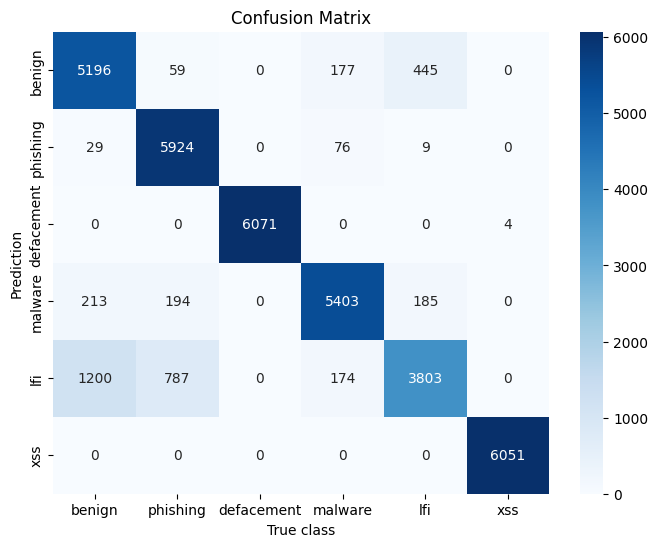

In [18]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["benign", "phishing", "defacement", "malware", "lfi", "xss"],
            yticklabels=["benign", "phishing", "defacement", "malware", "lfi", "xss"])
plt.xlabel('True class')
plt.ylabel('Prediction')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import pickle
model.save("MaliciousUrlDetector.h5")

with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

with open("label_encoder.pkl", "wb") as handle:
    pickle.dump(label_encoder, handle)

In [33]:
#Url bening
new_url = "google.com/search?q=machine+learning&sca_esv=8b75abeabf827e33&sxsrf=AHTn8zouO3lO89LOw63MDFU94DXyJiRFag%3A1738751046285&source=hp&ei=RjyjZ5KBDtKckdUPtNuK2QM&iflsig=ACkRmUkAAAAAZ6NKVplvTQ09z4NYDAonvpzdPjuxXN8g&ved=0ahUKEwiSvNqzqKyLAxVSTqQEHbStIjsQ4dUDCBk&uact=5&oq=machine+learning&gs_lp=Egdnd3Mtd2l6IhBtYWNoaW5lIGxlYXJuaW5nMggQABiABBixAzILEAAYgAQYsQMYgwEyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABEiGH1DzC1j0HXABeACQAQCYAbcDoAHzDqoBCTkuMy4yLjAuMbgBA8gBAPgBAZgCEKACtxCoAgrCAgcQIxgnGOoCwgIHEC4YJxjqAsICDBAjGIAEGBMYJxiKBcICChAjGIAEGCcYigXCAg4QLhiABBixAxjRAxjHAcICDhAAGIAEGLEDGIMBGIoFwgIREC4YgAQYsQMY0QMYgwEYxwHCAgsQLhiABBjRAxjHAcICBRAuGIAEwgIQEC4YgAQYsQMY0QMYxwEYCsICDhAuGIAEGLEDGMcBGK8BwgIOEC4YgAQYxwEYjgUYrwGYAxXxBS_IeI-46C_HkgcJOS40LjIuMC4xoAeUbg&sclient=gws-wiz"

# Url defacement
#new_url = "http://google.com/index.php?format=feed&type=atom"


print(features_df["type"].value_counts())

# 1. URL özelliklerini çıkar
extractor = FeatureExtractor(new_url)
url_features = extractor.run()

# 2. Tokenize et ve pad et
sequence = tokenizer.texts_to_sequences([new_url])
padded_sequence = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')

# 3. Ekstra özellikleri hazırlama
extra_features = np.array([[url_features['entropy'], url_features['digits'],
                            url_features['url_length'], url_features['param_nums'],
                            url_features['has_http'], url_features['has_https'],
                            url_features['is_ip'], url_features['num_%20'],
                            url_features['num_@']]]).astype(np.int32)

# 4. Model ile tahmin yap
prediction = model.predict([padded_sequence, extra_features])
predicted_class = np.argmax(prediction, axis=1)
class_labels = label_encoder.inverse_transform(predicted_class)
print(f"Label predicted: {class_labels}")
print(f"Predictions: {prediction}")

type
0    30000
1    30000
2    30000
3    30000
4    30000
5    30000
Name: count, dtype: int64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Label predicted: ['defacement']
Predictions: [[9.060e-06 8.389e-01 0.000e+00 1.630e-02 1.447e-01 0.000e+00]]
